In [5]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt 

import random

import platform_opt
from players import *

In [6]:
# SIMULATION PARAMETERS
T = 100                # number of timesteps
M = 200                # M >= T
pi_a, pi_b = 0.5, 0.5  # number of members in groups a and b
m = 20                 # size of unit mass

# indexed (user group, article group).
# probability of like | click, user group, article group
P = {( 1,  1):  0.8,
     ( 1, -1):  0.01,
     (-1,  1):  0.05,
     (-1, -1):  0.2} 

# prob click | group membership
probclick = {1: 0.5, -1: 0.5}  

# utility for liking, known to both user and platform,
# varies by (article shown, user group) pair
v = {( 1,  1):   1.,
     (-1,  1):   0.,
     ( 1, -1):   0.,
     (-1, -1):   1. }

# cost of clicking, known to both user and platform,
# it is constant across group/source
c = 1

# transition probability across groups at time t + 1
q = {1: 0.8, -1: 0.8}

# approximation parameter for approximately equal probability
# of showing articles |theta - 1/2| <= epsilon
epsilon = 0.4  


# platform chooses their probability for showing article a by maximizing
# expected clickthrough rate subject to fairness constraints
# probshowA = platform_opt.optimize(epsilon, M * pi_a, M, T,
#                                   P[('1', '1')], P[('-1', '1')],
#                                   PLA=problike[1], PLB=problike[-1],
#                                   muA = probclick[1], muB=probclick[-1])
probshowA = 0.2

In [7]:
old_u = []
time_data_diff = []


def coin_toss(p):
    '''Mechanism to decide between A (1) or B (-1).'''
    return 2 * np.random.binomial(1, p) - 1
    

for t in range(1, T + 1):
    new_u = []  # list of new players that arrive at the timestep

    if t == 1:  # initial mass of users arrives
        for i in range(m):
            g = coin_toss(pi_a)
            a = coin_toss(probshowA)
            old_u.append(Player(group=g, article=a))

    else:
        for user in old_u:
            
            # now users are replaced in place (kinda)
            if random.uniform(0, 1) <= q[user.group]:  # if next person is drawn by homophily
                new_user = Player(group=user.group)
                if user.shared:
                    new_user.article = user.article
                else:
                    new_user.article = coin_toss(probshowA)
                
            else:
                new_user = Player(group=-user.group) 
                new_user.article = coin_toss(probshowA)

            new_user.clicked = calcclick(P[(new_user.group,  1)],
                                         P[(new_user.group, -1)],
                                         probshowA,
                                         v=v[(new_user.article, new_user.group)],
                                         c=1)

            # decide if user shares article, according to P.
            if new_user.clicked == 1:  # this is wrong, since we want a probability of liking without clicking
                if random.uniform(0, 1) <= P[(new_user.group, new_user.article)]:
                    new_user.shared = True
            else:
                new_user.shared = False

            #add user to list
            new_u.append(new_user)

        old_u = new_u
    time_data_diff.append(np.sum([user.article for user in old_u]) / float(m))

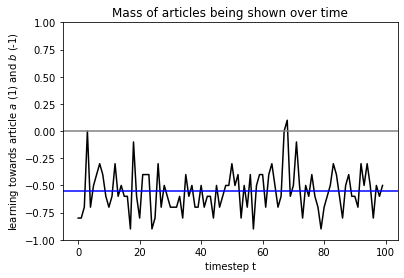

In [8]:
plt.plot(time_data_diff, color='black')
plt.title("Mass of articles being shown over time")
plt.ylabel("learning towards article $a$ (1) and $b$ (-1)")
plt.xlabel("timestep t")
plt.ylim((-1,1))
plt.axhline(y=0,color='grey')
plt.axhline(y=np.average(time_data_diff),color='blue')
#plt.axhline(y=epsilon,color='red')
#plt.axhline(y=-1 * epsilon,color='red')
plt.show()